In [ ]:
from custom_model import get_tokenization, MatMulFreeLM, Trainer
from matplotlib import pyplot as plt
import torch

### Software latency evaluation
Here we will evaluate the latency of the software implementation of our model. We redefine the `Block` module that is referenced by hardware implementation, and sandwitch the call to the token mixer module with a `perf_counter` call to measure the time for a forward pass through the model (unit is in s).

In [8]:
from torch import nn
from mmfreelm.layers import HGRNBitAttention
from time import perf_counter

class Block(nn.Module):
    def __init__(self, hidden_size, n_head, seq_len):
        super().__init__()
        self.attn = HGRNBitAttention(hidden_size=hidden_size, num_heads=n_head)


    def forward(self, x):
        t0 = perf_counter()
        x = self.attn(x)[0]
        t1 = perf_counter()
        if self.training:
            return x
        else:
            return x, t1 - t0
        
model = Block(64, 1, 1).cuda()
model.eval()
x, time = model(torch.rand(1, 128,64, device='cuda'))
print(f"The time taken for the forward pass is {time} seconds")

The time taken for the forward pass is 0.0013229087926447392 seconds


### Training from scratch

MatMulFreeLM(
  (transformer): MatMulFreeModel(
    (emb): Embedding(64, 64)
    (attention): ModuleList(
      (0): Block(
        (attn): HGRNBitAttention(
          (i_proj): FusedBitLinear(
            in_features=64, out_features=64, bias=False
            (norm): RMSNorm(64, eps=1e-08)
          )
          (f_proj): FusedBitLinear(
            in_features=64, out_features=64, bias=False
            (norm): RMSNorm(64, eps=1e-08)
          )
          (g_proj): FusedBitLinear(
            in_features=64, out_features=64, bias=False
            (norm): RMSNorm(64, eps=1e-08)
          )
          (g_norm): FusedRMSNormSwishGate()
          (o_proj): FusedBitLinear(
            in_features=64, out_features=64, bias=False
            (norm): RMSNorm(64, eps=1e-08)
          )
        )
      )
    )
    (ln): RMSNorm(64, eps=1e-05)
  )
  (head): FusedBitLinear(
    in_features=64, out_features=64, bias=False
    (norm): RMSNorm(64, eps=1e-08)
  )
)
running on cuda
Iteration 1/15000:

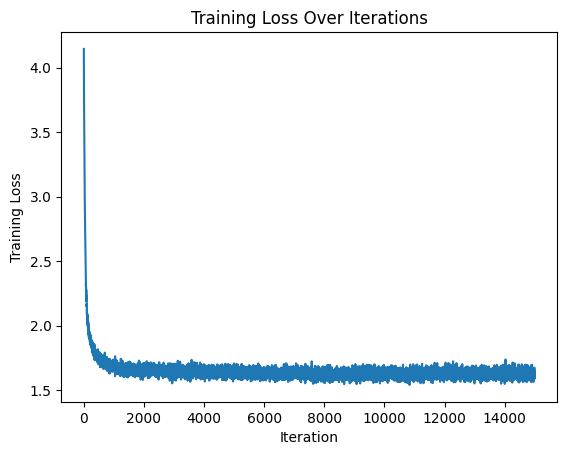

In [3]:
config = {
	'embedding_dim': 64,
	'seq_len': 128,
	'vocab_size': 64,
	'n_layer': 1
}

tokenizer, dataset = get_tokenization(config['vocab_size'], config['seq_len'])

model = MatMulFreeLM(**config)
print(model)
learning_rate = 1e-3
max_iters = 15000
story_trainer = Trainer(model, dataset, tokenizer, learning_rate, batch_size=64, max_iters=15000)
story_trainer.run('story')
plt.plot(story_trainer.train_losses)
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
# plt.yscale('log')
plt.show()

In [4]:
torch.save({'state_dict': model.state_dict(), 'config': config}, 'model.pth')

### Load checkpoint & inference

In [5]:
ckpt = torch.load('model.pth')
config = ckpt['config']
tokenizer, dataset = get_tokenization(config['vocab_size'], config['seq_len'])
model = MatMulFreeLM(**config).cuda()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In your linux terminal, have `nvidia-smi -l 1` running before you run the following code cell to monitor GPU usage and power consumption. For our testing, we used a RTX 4070 GPU, which consumed 34W during idle and 40W during inference.

In [6]:
trainer = Trainer(model, dataset, tokenizer, learning_rate=0, batch_size=64)
trainer.generate()

running on cuda
Story (1): 
once upon a time.lily learifule and a was ding thak a laugh, whing her was so bunny to soart and had lict of thim sad, "i'm she love to forgainnted.   briend looks over lannd a lwith fir whiles winds a she foor on. they annix fix was our outhe feloure.   be don't the watch with so high. she dray's with! lily and side take tourn the hought with head she wo sticrouldn't were what halppy's to was a little facore.  he sanky founxing is it truwht the loging to druces. he lia would foarnst ouldby and sad by ann a lily.  lily's nicy toirgouge, liked things a looked of him foriends tankey strough mom wo so to help his itte woomde too! he dightly, mom with fixing is had birds shing.   lily dry, that teirn. she the wogethatin his him tham! lily with so a said. lily, the somale lily againted lol. she didn't was lew a bir fraid, and lil hought their moum wings one froanns a loudng to by big her. the seat and beallay thince wore ou timcomching toure feltber on a he loot 